In [1]:
# Preamble (system)
import sys
import os

if sys.version_info[0] < 3:
  raise AssertionError('Please run this notebook with Python 3.')

# Preamble (tools)
import numpy as np
import collections
import contextlib
import functools
import itertools
import more_itertools

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Preamble (ML)
np.random.seed(2027)  # set random seed

#import tensorflow as tf
#tf.random.set_seed(2027)  # set random seed

#import dask
#import dask.array as da

In [2]:
# Preamble (EMTF)
from emtf_nbtools import get_logger, get_colormap, emtf_nbtools

# Get plot style and color map
plt.style.use('tdrstyle.mplstyle')
cm = get_colormap()

# Get logger
logger = get_logger()
logger.info('Using cmssw      : {}'.format(os.environ.get('CMSSW_VERSION', 'N/A')))
logger.info('Using python     : {}'.format(sys.version.replace('\n', '')))
logger.info('Using numpy      : {}'.format(np.__version__))
logger.info('Using matplotlib : {}'.format(matplotlib.__version__))
#logger.info('Using tensorflow : {}'.format(tf.__version__))
#logger.info('Using keras      : {}'.format(tf.keras.__version__))
#logger.info('.. list devices  : {}'.format(tf.config.list_physical_devices()))
#logger.info('Using dask       : {}'.format(dask.__version__))

[INFO    ] Using cmssw      : CMSSW_11_1_7
[INFO    ] Using python     : 3.9.7 (default, Sep 16 2021, 13:09:58) [GCC 7.5.0]
[INFO    ] Using numpy      : 1.20.3
[INFO    ] Using matplotlib : 3.4.2


In [3]:
# Settings

# zone: (0,1,2) -> eta=(1.98..2.5, 1.55..1.98, 1.2..1.55)
zone = 0
#zone = 1
#zone = 2

# timezone: (0,1,2) -> BX=(0,-1,-2)
timezone = 0

maxevents = 200_000
#maxevents = -1

# Input files
rates_fname = 'rates.211015.npz'

logger.info('Using settings   : |')
logger.info('.. zone          : {}'.format(zone))
logger.info('.. timezone      : {}'.format(timezone))
logger.info('.. maxevents     : {}'.format(maxevents))

[INFO    ] Using settings   : |
[INFO    ] .. zone          : 0
[INFO    ] .. timezone      : 0
[INFO    ] .. maxevents     : 200000


### Load data

In [4]:
def load_rates():
  logger.info('Loading from {}'.format(rates_fname))
  rates = {}
  with np.load(rates_fname) as loaded:
    rates.update(loaded)
  logger.info('rates: {}'.format({k: (v.shape, v.dtype.name) for (k, v) in rates.items()}))
  return rates

In [5]:
# Load data
rates_data = load_rates()

[INFO    ] Loading from rates.211015.npz
[INFO    ] rates: {'rate_vs_pt': ((200000,), 'float32'), 'rate_vs_pt_2': ((200000,), 'float32'), 'rate_vs_pt_3': ((200000,), 'float32'), 'rate_vs_qual': ((200000,), 'int32'), 'rate_vs_pt_1': ((200000,), 'float32')}


### Plot results

In [6]:
def make_hist(a, bins=10, range=None):
  _range = range
  hist, edges = np.histogram(a, bins=bins, range=_range)
  hist[-1] += np.count_nonzero(a > _range[1])  # includes overflow
  hist[0] = 0  # excludes underflow
  new_hist = emtf_nbtools.DumbHist(edges, dtype=hist.dtype, err_dtype=np.float32)
  new_hist._bin_content = hist
  new_hist._bin_error = np.sqrt(hist)
  return new_hist


def make_ptcut(hist):
  new_hist = emtf_nbtools.DumbHist(hist.edges, dtype=hist.dtype, err_dtype=hist.err_dtype)
  binsum = 0
  binerr2 = 0.
  for new_b, b in zip(reversed(new_hist), reversed(hist)):
    value, error = b.value, b.error
    binsum += value
    binerr2 += error ** 2
    new_b.value = binsum
    new_b.error = np.sqrt(binerr2)
  return new_hist


def make_rate(hist, nevents):
  orbitFreq = 11.246  # kHz
  nCollBunches = 2760  # assume lumi=8e34, PU=200, xsec_pp=80mb
  nZeroBiasEvents = float(nevents)
  convFactor = orbitFreq * nCollBunches / nZeroBiasEvents
  hist.scale(convFactor)
  return hist

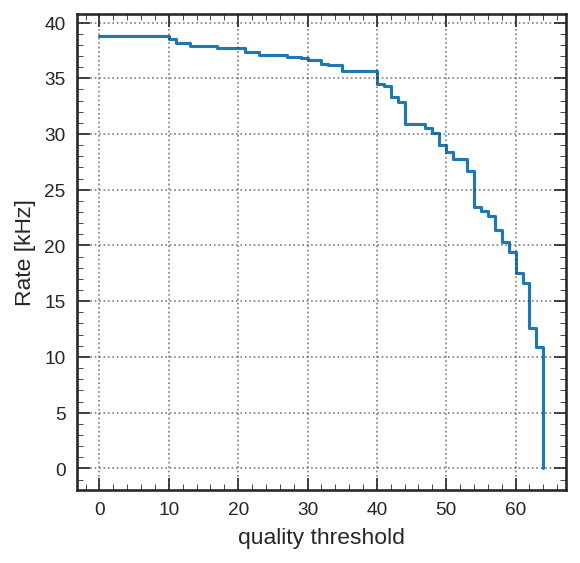

In [7]:
# Apply quality cut
rate_vs_qual = rates_data['rate_vs_qual']
nevents = len(rate_vs_qual)
hist = make_hist(rate_vs_qual, bins=64, range=(0, 64))
hist = make_ptcut(hist)
hist = make_rate(hist, nevents)

# Plot
fig, ax = plt.subplots()
ax.step(hist.edges, hist.steps, where='post', lw=1.5)
ax.set_xlabel(r'quality threshold')
ax.set_ylabel(r'Rate [kHz]')
plt.show()

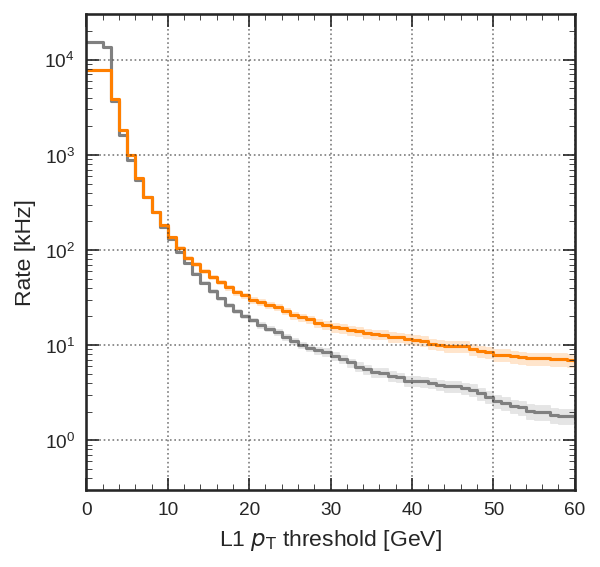

[INFO    ] rate @10 GeV: 129.619 vs 137.192
[INFO    ] rate @20 GeV: 18.375 vs 30.108
[INFO    ] rate @30 GeV: 7.698 vs 15.364
[INFO    ] rate @40 GeV: 4.221 vs 11.329
[INFO    ] rate @50 GeV: 2.607 vs 7.915


In [8]:
# Rates vs pt (comparison with p2tdr)
hist_p2tdr = np.array([
  1.5196178e+04, 1.5196178e+04, 1.3661612e+04, 3.7203918e+03, 1.5985065e+03,
  8.7778180e+02, 5.3896051e+02, 3.5657556e+02, 2.4818753e+02, 1.7537012e+02,
  1.2961870e+02, 9.5537918e+01, 7.3500259e+01, 5.6428829e+01, 4.5254803e+01,
  3.7184673e+01, 3.0976883e+01, 2.6383116e+01, 2.2844675e+01, 2.0361557e+01,
  1.8375065e+01, 1.6326492e+01, 1.4898701e+01, 1.3781299e+01, 1.2105194e+01,
  1.1049870e+01, 1.0118701e+01, 9.3737659e+00, 8.8771429e+00, 8.5046749e+00,
  7.6976619e+00, 7.2010388e+00, 6.5802593e+00, 5.9594803e+00, 5.5870128e+00,
  5.2145452e+00, 5.1524673e+00, 4.7799997e+00, 4.5937662e+00, 4.2212987e+00,
  4.2212987e+00, 4.1592207e+00, 4.0350647e+00, 3.8488309e+00, 3.7246752e+00,
  3.7246752e+00, 3.5384414e+00, 3.4142857e+00, 3.1038959e+00, 2.8555844e+00,
  2.6072726e+00, 2.4831169e+00, 2.2968831e+00, 2.2348051e+00, 2.0485713e+00,
  1.9864935e+00, 1.9864935e+00, 1.8623376e+00, 1.8002597e+00, 1.8002597e+00,
  1.6761038e+00, 1.4898701e+00, 1.3036363e+00, 1.0553247e+00, 1.0553247e+00,
  9.3116879e-01, 9.3116879e-01, 8.0701298e-01, 7.4493504e-01, 7.4493504e-01,
  7.4493504e-01, 6.2077922e-01, 5.5870128e-01, 4.9662337e-01, 4.9662337e-01,
  4.9662337e-01, 4.3454543e-01, 4.3454543e-01, 4.3454543e-01, 3.7246752e-01,
  3.1038961e-01, 2.4831168e-01, 2.4831168e-01, 2.4831168e-01, 2.4831168e-01,
  2.4831168e-01, 2.4831168e-01, 2.4831168e-01, 2.4831168e-01, 2.4831168e-01,
  2.4831168e-01, 2.4831168e-01, 2.4831168e-01, 2.4831168e-01, 2.4831168e-01,
  2.4831168e-01, 2.4831168e-01, 2.4831168e-01, 2.4831168e-01, 1.8623376e-01,
], dtype=np.float32)

hist_err_p2tdr = np.array([
  30.713957  , 30.713957  , 29.12189   , 15.197177  ,  9.9615237 ,
   7.381793  ,  5.7842499 ,  4.7048347 ,  3.9251707 ,  3.2994867 ,
   2.8366281 ,  2.4353224 ,  2.1360578 ,  1.8716261 ,  1.6761038 ,
   1.5193246 ,  1.3867157 ,  1.2797691 ,  1.190861  ,  1.1242789 ,
   1.0680289 ,  1.0067347 ,  0.961707  ,  0.92494018,  0.86687098,
   0.82822275,  0.79255783,  0.76282625,  0.74234395,  0.72660342,
   0.69127046,  0.66859966,  0.6391313 ,  0.60823691,  0.58892286,
   0.56895353,  0.56555677,  0.54473154,  0.53401446,  0.51190764,
   0.51190764,  0.50812967,  0.50048819,  0.48880203,  0.4808535 ,
   0.4808535 ,  0.46867802,  0.46038218,  0.43895718,  0.42103294,
   0.4023109 ,  0.39261524,  0.37760525,  0.37246752,  0.3566105 ,
   0.35116575,  0.35116575,  0.34001477,  0.33429983,  0.33429983,
   0.32256633,  0.30411846,  0.28447677,  0.25595382,  0.25595382,
   0.24042675,  0.24042675,  0.22382512,  0.21504422,  0.21504422,
   0.21504422,  0.19630762,  0.18623376,  0.17558287,  0.17558287,
   0.17558287,  0.16424274,  0.16424274,  0.16424274,  0.15205923,
   0.13881045,  0.12415584,  0.12415584,  0.12415584,  0.12415584,
   0.12415584,  0.12415584,  0.12415584,  0.12415584,  0.12415584,
   0.12415584,  0.12415584,  0.12415584,  0.12415584,  0.12415584,
   0.12415584,  0.12415584,  0.12415584,  0.12415584,  0.10752211,
], dtype=np.float32)


# Plot
fig, ax = plt.subplots()

rate_vs_pt = rates_data['rate_vs_pt']
nevents = len(rate_vs_pt)
hist = make_hist(rate_vs_pt, bins=100, range=(0, 100))
hist = make_ptcut(hist)
hist = make_rate(hist, nevents)

hist_ref = emtf_nbtools.DumbHist(hist.edges, dtype=hist.dtype, err_dtype=hist.err_dtype)
hist_ref._bin_content = hist_p2tdr
hist_ref._bin_error = hist_err_p2tdr

h = hist_ref
color = 'gray'
ax.step(h.edges, h.steps, where='post', color=color, lw=1.5)
ax.fill_between(h.edges, h.steps - h.err_steps, h.steps + h.err_steps, step='post', color=color, alpha=0.2)
h = hist
color = '#ff7f00'
ax.step(h.edges, h.steps, where='post', color=color, lw=1.5)
ax.fill_between(h.edges, h.steps - h.err_steps, h.steps + h.err_steps, step='post', color=color, alpha=0.2)

ax.set_xlabel(r'L1 $p_{\mathrm{T}}$ threshold [GeV]')
ax.set_ylabel(r'Rate [kHz]')
ax.set_xlim(0, 60)
ax.set_ylim(0.3, 3e4)
ax.set_yscale('log')
plt.show()

logger.info("rate @10 GeV: {:.3f} vs {:.3f}".format(hist_ref[10].value, hist[10].value))
logger.info("rate @20 GeV: {:.3f} vs {:.3f}".format(hist_ref[20].value, hist[20].value))
logger.info("rate @30 GeV: {:.3f} vs {:.3f}".format(hist_ref[30].value, hist[30].value))
logger.info("rate @40 GeV: {:.3f} vs {:.3f}".format(hist_ref[40].value, hist[40].value))
logger.info("rate @50 GeV: {:.3f} vs {:.3f}".format(hist_ref[50].value, hist[50].value))

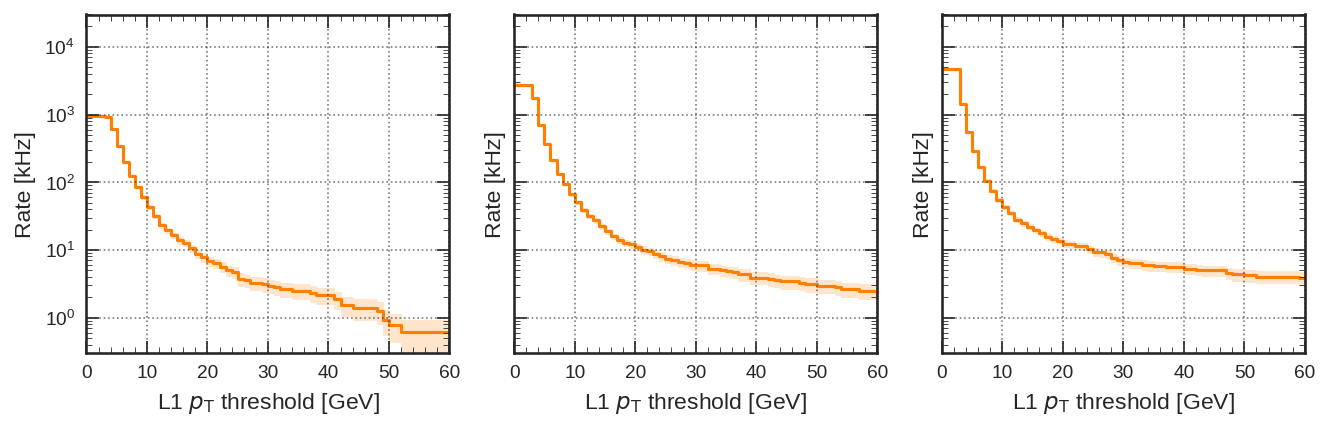

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3), tight_layout=True, sharex=True, sharey=True)

for i in range(3):
  ax = axs[i]
  if i == 0:
    rate_vs_pt = rates_data['rate_vs_pt_1']
  elif i == 1:
    rate_vs_pt = rates_data['rate_vs_pt_2']
  elif i == 2:
    rate_vs_pt = rates_data['rate_vs_pt_3']

  nevents = len(rate_vs_pt)
  hist = make_hist(rate_vs_pt, bins=100, range=(0, 100))
  hist = make_ptcut(hist)
  hist = make_rate(hist, nevents)

  h = hist
  color = '#ff7f00'
  ax.step(h.edges, h.steps, where='post', color=color, lw=1.5)
  ax.fill_between(h.edges, h.steps - h.err_steps, h.steps + h.err_steps, step='post', color=color, alpha=0.2)

  ax.set_xlabel(r'L1 $p_{\mathrm{T}}$ threshold [GeV]')
  ax.set_ylabel(r'Rate [kHz]')
  ax.set_xlim(0, 60)
  ax.set_ylim(0.3, 3e4)
  ax.set_yscale('log')

plt.show()